In [1]:
from __future__ import absolute_import, division, print_function

import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import reverb
import sys

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils
from tf_agents.networks import q_rnn_network


sys.path.append('/home/jorge/Documentos/TFG/entorno')
from trading_env_2 import TradingEnv

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

tf.config.list_physical_devices('GPU')

root_dir = '/home/jorge/Documentos/TFG/puntos_control'

root_dir = os.path.expanduser(root_dir)
train_dir = os.path.join(root_dir, 'train')

2023-03-24 13:42:09.675908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 13:42:09.747940: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 13:42:10.142466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64:/home/jorge/miniconda3/envs/tf/lib/
2023-03-24 13:4

# Preparacion de los datos

In [2]:
df = pd.read_csv('/home/jorge/Documentos/TFG/datasets/BTCUSDT_spot_1m_.csv', index_col = 'open_time')
df

,open,high,low,close,volume,rvol,high_per,low_per,close_per,close_money
open_time,,,,,,,,,,
2019-01-11 00:00:00,3585.88,3589.07,3585.26,3586.70,24.13,0.58,0.09,0.02,0.02,0.23
2019-01-11 00:01:00,3586.30,3586.70,3557.52,3567.60,228.68,6.43,0.01,0.80,-0.52,-5.24
2019-01-11 00:02:00,3567.60,3579.69,3560.88,3576.09,136.27,4.63,0.34,0.19,0.24,2.37
2019-01-11 00:03:00,3576.61,3579.79,3567.63,3577.53,48.13,1.93,0.09,0.25,0.03,0.26
2019-01-11 00:04:00,3577.52,3579.99,3571.44,3577.73,25.05,1.05,0.07,0.17,0.01,0.06
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:55:00,16540.42,16540.92,16537.71,16539.28,36.24,0.31,0.00,0.02,-0.01,-0.07
2022-12-31 23:56:00,16538.65,16540.53,16538.38,16540.52,38.59,0.39,0.01,0.00,0.01,0.11
2022-12-31 23:57:00,16540.52,16540.79,16535.05,16537.78,53.36,0.94,0.00,0.03,-0.02,-0.17


In [3]:
df_sc = df[['close_per']]
df_sc.head()

,close_per
open_time,
2019-01-11 00:00:00,0.02
2019-01-11 00:01:00,-0.52
2019-01-11 00:02:00,0.24
2019-01-11 00:03:00,0.03
2019-01-11 00:04:00,0.01


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])

df_sc

/tmp/ipykernel_9762/3553793866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])
/tmp/ipykernel_9762/3553793866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc[['close_sc','rvol']] = scaler.fit_transform(df[['close_per','rvol']])


,close_per,close_sc,rvol
open_time,,,
2019-01-11 00:00:00,0.02,0.524590,0.002214
2019-01-11 00:01:00,-0.52,0.487705,0.024549
2019-01-11 00:02:00,0.24,0.539617,0.017676
2019-01-11 00:03:00,0.03,0.525273,0.007368
2019-01-11 00:04:00,0.01,0.523907,0.004009
...,...,...,...
2022-12-31 23:55:00,-0.01,0.522541,0.001184
2022-12-31 23:56:00,0.01,0.523907,0.001489
2022-12-31 23:57:00,-0.02,0.521858,0.003589


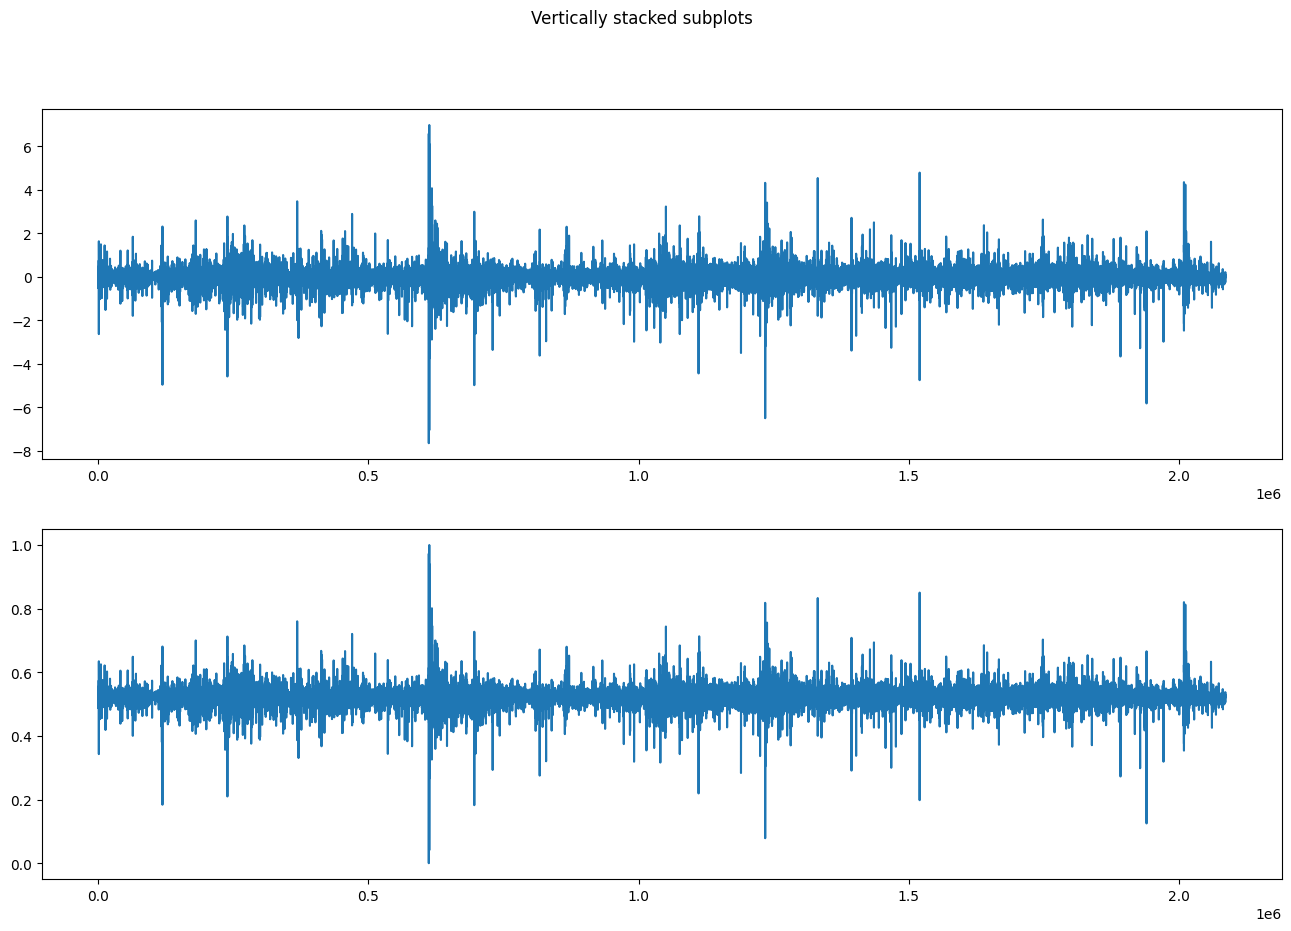

In [5]:
fig, axs = plt.subplots(2,figsize=(16,10))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df.iloc[:,8].values)
axs[1].plot(df_sc.iloc[:,1].values)

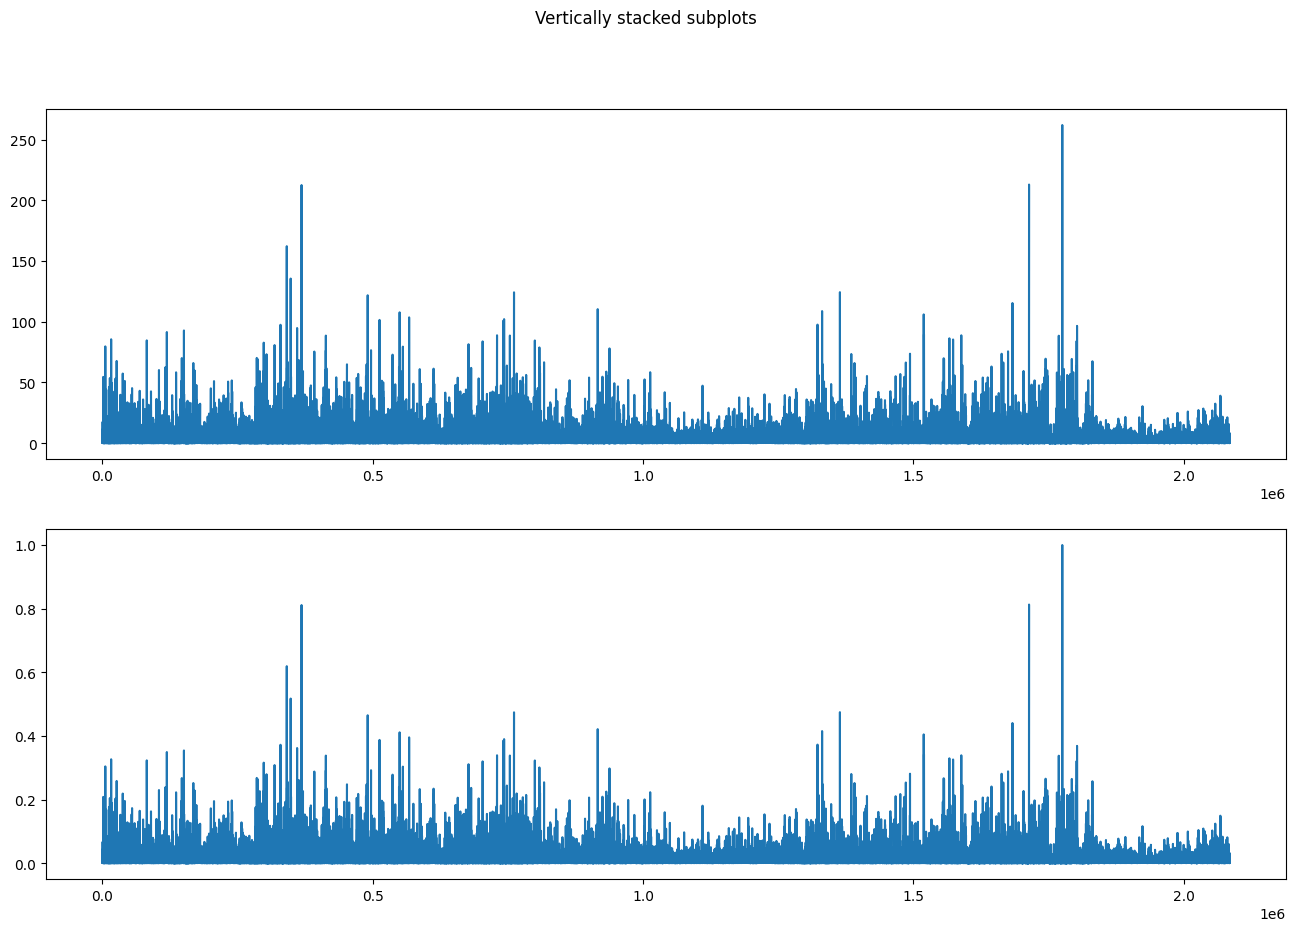

In [6]:
fig, axs = plt.subplots(2,figsize=(16,10))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df.iloc[:,5].values)
axs[1].plot(df_sc.iloc[:,2].values)

In [7]:
from random import shuffle

def create_time_series(dataset):    
    X = []
    
    for i in range(20,dataset.shape[0],20):        
        X.append(dataset[i-20:i,:])
        
    return np.array(X)

In [8]:
from sklearn.model_selection import train_test_split

#df_diff_sc = arr_diff[:,3].reshape(-1, 1)

X = create_time_series(np.array(df_sc[['close_per','close_sc','rvol']]))
X.shape

(104271, 20, 3)

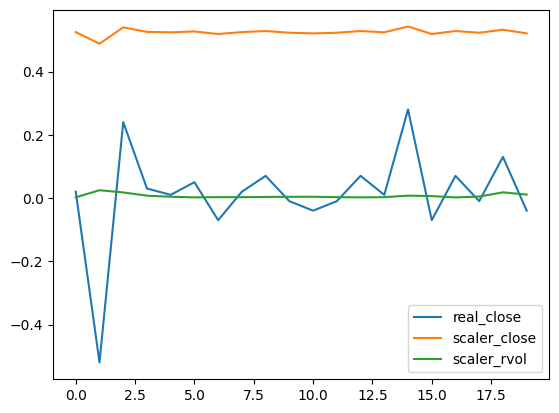

In [9]:
plt.plot(X[0])
plt.legend(('real_close','scaler_close','scaler_rvol'))
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.10,random_state = 42)
X_train.shape,X_test.shape

((93843, 20, 3), (10428, 20, 3))

# Hiperparamatros

In [11]:
num_iterations = 500000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 1000000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 1  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

checkpoint_interval = 100000
buffer_interval = num_iterations/2

# Entorno

In [12]:
env = TradingEnv(X_train)

In [13]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(10, 2), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [14]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [15]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)


In [16]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[0.52663934, 0.00511587],
       [0.5191257 , 0.00637575],
       [0.5300546 , 0.00744474],
       [0.51775956, 0.00355057],
       [0.5280055 , 0.00503951],
       [0.534153  , 0.01118619],
       [0.51980877, 0.01095713],
       [0.52868855, 0.00660482],
       [0.5239071 , 0.00809377],
       [0.5136612 , 0.01004085]], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([[0.5191257 , 0.00637575],
       [0.5300546 , 0.00744474],
       [0.51775956, 0.00355057],
       [0.5280055 , 0.00503951],
       [0.534153  , 0.01118619],
       [0.51980877, 0.01095713],
       [0.52868855, 0.00660482],
       [0.5239071 , 0.00809377],
       [0.5136612 , 0.01004085],
       [0.5191257 , 0.00626121]], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(2, dtype=int32)})

In [17]:
train_py_env = TradingEnv(X_train)
eval_py_env = TradingEnv(X_test)

In [18]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agente

In [19]:
'''
fc_layer_params = (100, 100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

#Capa de preprocessamiento
preprocessing_layer = tf.keras.layers.Flatten()

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential([preprocessing_layer] + dense_layers + [q_values_layer])
'''

lstm_size=(50,50)

#create a q_RNNnet
q_net = q_rnn_network.QRnnNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    input_fc_layer_params=None,
    lstm_size=lstm_size,
    output_fc_layer_params=None)    

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2023-03-24 13:42:25.616519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Politicas

In [21]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [22]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [23]:
example_environment = tf_py_environment.TFPyEnvironment(
    TradingEnv(X_train))

In [24]:
time_step = example_environment.reset()

In [25]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())

# Métricas y evaluación

In [26]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    total_steps = 0.0
    for _ in range(num_episodes):

        policy_state = policy.get_initial_state(environment.batch_size)
        time_step = environment.reset()
        episode_return = 0.0
        episode_steps = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step,policy_state)
            time_step = environment.step(action_step.action)
            policy_state = action_step.state
            episode_return = time_step.reward
            episode_steps += 1.0
        total_return = episode_return
        total_steps += episode_steps

    avg_return = total_return / num_episodes
    avg_steps = total_steps / num_episodes
    return avg_return.numpy()[0],avg_steps


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [27]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

(0.18, 5.0)

# Buffer de reproducción

In [28]:
table_name = 'priotity_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Prioritized(0.8),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpm4fhaq7x.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpm4fhaq7x
[reverb/cc/platform/default/server.cc:71] Started replay server on port 39973


In [29]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(10, 2), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [30]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

# Recolección de datos 

In [31]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0., dtype=float32),
  'observation': array([[0.51844263, 0.00618486],
        [0.5191257 , 0.01424045],
        [0.50614756, 0.09479632],
        [0.5218579 , 0.03332952],
        [0.52937156, 0.02351773],
        [0.5239071 , 0.0303898 ],
        [0.53825134, 0.016073  ],
        [0.5191257 , 0.02011988],
        [0.51297814, 0.01504219],
        [0.51980877, 0.00954453]], dtype=float32),
  'reward': array(-0.05, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [32]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 10, 2), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [33]:
iterator = iter(dataset)
print(iterator)

# Checkpoint

In [34]:
train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    global_step=train_step_counter
)

In [35]:
train_checkpointer.initialize_or_restore()

In [36]:
agent.train_step_counter.numpy()

1000000

# Entrenando al agente

In [ ]:
try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Evaluate the agent's policy once before training.
avg_return,_ = compute_avg_return(eval_env, agent.collect_policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
policy_state = agent.policy.get_initial_state(train_env.batch_size)
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, policy_state = collect_driver.run(time_step,policy_state)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return,avg_steps = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Steps = {1}, Average Return = {2}'.format(step,avg_steps,avg_return))
        returns.append(avg_return)
        
    if step % checkpoint_interval == 0:
        train_checkpointer.save(train_step_counter)
                
    #if step % buffer_interval ==0:
    #    rb_checkpointer.save(global_step=global_step.numpy())

# Visualización

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=2.5)

# Test

In [37]:
test_py_env = TradingEnv(X_test)
test_env = tf_py_environment.TFPyEnvironment(test_py_env)

In [38]:
avg_return,avg_steps = compute_avg_return(test_env, agent.policy, num_eval_episodes)
returns_test = [avg_return]
steps_test = [avg_steps]

In [39]:
for i in range(X_test.shape[0]):
    avg_return,avg_steps = compute_avg_return(test_env, agent.policy, num_eval_episodes)
    print('iteration = {0}: steps = {1}, Return = {2}'.format(i,avg_steps, avg_return))
    returns_test.append(avg_return)
    steps_test.append(avg_steps)

iteration = 0: steps = 1.0, Return = 0.0
iteration = 1: steps = 1.0, Return = 0.0
iteration = 2: steps = 1.0, Return = 0.0
iteration = 3: steps = 1.0, Return = 0.0
iteration = 4: steps = 1.0, Return = 0.0
iteration = 5: steps = 1.0, Return = 0.0
iteration = 6: steps = 2.0, Return = 0.0
iteration = 7: steps = 1.0, Return = 0.0
iteration = 8: steps = 2.0, Return = 0.0
iteration = 9: steps = 2.0, Return = 0.0
iteration = 10: steps = 1.0, Return = 0.0
iteration = 11: steps = 1.0, Return = 0.0
iteration = 12: steps = 1.0, Return = 0.0
iteration = 13: steps = 1.0, Return = 0.0
iteration = 14: steps = 1.0, Return = 0.0
iteration = 15: steps = 1.0, Return = 0.0
iteration = 16: steps = 1.0, Return = 0.0
iteration = 17: steps = 2.0, Return = 0.0
iteration = 18: steps = 1.0, Return = 0.0
iteration = 19: steps = 1.0, Return = 0.0
iteration = 20: steps = 1.0, Return = 0.0
iteration = 21: steps = 1.0, Return = 0.0
iteration = 22: steps = 1.0, Return = 0.0
iteration = 23: steps = 1.0, Return = 0.0
it

iteration = 197: steps = 1.0, Return = 0.0
iteration = 198: steps = 1.0, Return = 0.0
iteration = 199: steps = 1.0, Return = 0.0
iteration = 200: steps = 2.0, Return = 0.0
iteration = 201: steps = 2.0, Return = 0.0
iteration = 202: steps = 1.0, Return = 0.0
iteration = 203: steps = 1.0, Return = 0.0
iteration = 204: steps = 1.0, Return = 0.0
iteration = 205: steps = 1.0, Return = 0.0
iteration = 206: steps = 1.0, Return = 0.0
iteration = 207: steps = 1.0, Return = 0.0
iteration = 208: steps = 1.0, Return = 0.0
iteration = 209: steps = 2.0, Return = 0.0
iteration = 210: steps = 1.0, Return = 0.0
iteration = 211: steps = 1.0, Return = 0.0
iteration = 212: steps = 1.0, Return = 0.0
iteration = 213: steps = 1.0, Return = 0.0
iteration = 214: steps = 1.0, Return = 0.0
iteration = 215: steps = 1.0, Return = 0.0
iteration = 216: steps = 1.0, Return = 0.0
iteration = 217: steps = 1.0, Return = 0.0
iteration = 218: steps = 1.0, Return = 0.0
iteration = 219: steps = 1.0, Return = 0.0
iteration =

iteration = 390: steps = 1.0, Return = 0.0
iteration = 391: steps = 1.0, Return = 0.0
iteration = 392: steps = 1.0, Return = 0.0
iteration = 393: steps = 1.0, Return = 0.0
iteration = 394: steps = 2.0, Return = 0.0
iteration = 395: steps = 1.0, Return = 0.0
iteration = 396: steps = 1.0, Return = 0.0
iteration = 397: steps = 1.0, Return = 0.0
iteration = 398: steps = 1.0, Return = 0.0
iteration = 399: steps = 2.0, Return = 0.0
iteration = 400: steps = 1.0, Return = 0.0
iteration = 401: steps = 1.0, Return = 0.0
iteration = 402: steps = 1.0, Return = 0.0
iteration = 403: steps = 1.0, Return = 0.0
iteration = 404: steps = 1.0, Return = 0.0
iteration = 405: steps = 1.0, Return = 0.0
iteration = 406: steps = 1.0, Return = 0.0
iteration = 407: steps = 1.0, Return = 0.0
iteration = 408: steps = 1.0, Return = 0.0
iteration = 409: steps = 1.0, Return = 0.0
iteration = 410: steps = 1.0, Return = 0.0
iteration = 411: steps = 1.0, Return = 0.0
iteration = 412: steps = 1.0, Return = 0.0
iteration =

iteration = 583: steps = 1.0, Return = 0.0
iteration = 584: steps = 1.0, Return = 0.0
iteration = 585: steps = 1.0, Return = 0.0
iteration = 586: steps = 1.0, Return = 0.0
iteration = 587: steps = 1.0, Return = 0.0
iteration = 588: steps = 1.0, Return = 0.0
iteration = 589: steps = 1.0, Return = 0.0
iteration = 590: steps = 1.0, Return = 0.0
iteration = 591: steps = 1.0, Return = 0.0
iteration = 592: steps = 1.0, Return = 0.0
iteration = 593: steps = 1.0, Return = 0.0
iteration = 594: steps = 1.0, Return = 0.0
iteration = 595: steps = 1.0, Return = 0.0
iteration = 596: steps = 1.0, Return = 0.0
iteration = 597: steps = 2.0, Return = 0.0
iteration = 598: steps = 1.0, Return = 0.0
iteration = 599: steps = 1.0, Return = 0.0
iteration = 600: steps = 1.0, Return = 0.0
iteration = 601: steps = 1.0, Return = 0.0
iteration = 602: steps = 1.0, Return = 0.0
iteration = 603: steps = 1.0, Return = 0.0
iteration = 604: steps = 1.0, Return = 0.0
iteration = 605: steps = 1.0, Return = 0.0
iteration =

iteration = 781: steps = 1.0, Return = 0.0
iteration = 782: steps = 2.0, Return = 0.0
iteration = 783: steps = 1.0, Return = 0.0
iteration = 784: steps = 2.0, Return = 0.0
iteration = 785: steps = 1.0, Return = 0.0
iteration = 786: steps = 1.0, Return = 0.0
iteration = 787: steps = 1.0, Return = 0.0
iteration = 788: steps = 1.0, Return = 0.0
iteration = 789: steps = 1.0, Return = 0.0
iteration = 790: steps = 1.0, Return = 0.0
iteration = 791: steps = 1.0, Return = 0.0
iteration = 792: steps = 1.0, Return = 0.0
iteration = 793: steps = 2.0, Return = 0.0
iteration = 794: steps = 1.0, Return = 0.0
iteration = 795: steps = 1.0, Return = 0.0
iteration = 796: steps = 1.0, Return = 0.0
iteration = 797: steps = 1.0, Return = 0.0
iteration = 798: steps = 1.0, Return = 0.0
iteration = 799: steps = 2.0, Return = 0.0
iteration = 800: steps = 1.0, Return = 0.0
iteration = 801: steps = 1.0, Return = 0.0
iteration = 802: steps = 2.0, Return = 0.0
iteration = 803: steps = 2.0, Return = 0.0
iteration =

iteration = 977: steps = 1.0, Return = 0.0
iteration = 978: steps = 1.0, Return = 0.0
iteration = 979: steps = 1.0, Return = 0.0
iteration = 980: steps = 1.0, Return = 0.0
iteration = 981: steps = 2.0, Return = 0.0
iteration = 982: steps = 1.0, Return = 0.0
iteration = 983: steps = 1.0, Return = 0.0
iteration = 984: steps = 2.0, Return = 0.0
iteration = 985: steps = 1.0, Return = 0.0
iteration = 986: steps = 1.0, Return = 0.0
iteration = 987: steps = 1.0, Return = 0.0
iteration = 988: steps = 2.0, Return = 0.0
iteration = 989: steps = 1.0, Return = 0.0
iteration = 990: steps = 1.0, Return = 0.0
iteration = 991: steps = 1.0, Return = 0.0
iteration = 992: steps = 1.0, Return = 0.0
iteration = 993: steps = 1.0, Return = 0.0
iteration = 994: steps = 2.0, Return = 0.0
iteration = 995: steps = 1.0, Return = 0.0
iteration = 996: steps = 1.0, Return = 0.0
iteration = 997: steps = 1.0, Return = 0.0
iteration = 998: steps = 2.0, Return = 0.0
iteration = 999: steps = 1.0, Return = 0.0
iteration =

iteration = 1171: steps = 1.0, Return = 0.0
iteration = 1172: steps = 2.0, Return = 0.0
iteration = 1173: steps = 1.0, Return = 0.0
iteration = 1174: steps = 1.0, Return = 0.0
iteration = 1175: steps = 1.0, Return = 0.0
iteration = 1176: steps = 1.0, Return = 0.0
iteration = 1177: steps = 2.0, Return = 0.0
iteration = 1178: steps = 1.0, Return = 0.0
iteration = 1179: steps = 1.0, Return = 0.0
iteration = 1180: steps = 1.0, Return = 0.0
iteration = 1181: steps = 1.0, Return = 0.0
iteration = 1182: steps = 1.0, Return = 0.0
iteration = 1183: steps = 1.0, Return = 0.0
iteration = 1184: steps = 1.0, Return = 0.0
iteration = 1185: steps = 2.0, Return = 0.0
iteration = 1186: steps = 1.0, Return = 0.0
iteration = 1187: steps = 2.0, Return = 0.0
iteration = 1188: steps = 1.0, Return = 0.0
iteration = 1189: steps = 1.0, Return = 0.0
iteration = 1190: steps = 1.0, Return = 0.0
iteration = 1191: steps = 1.0, Return = 0.0
iteration = 1192: steps = 1.0, Return = 0.0
iteration = 1193: steps = 1.0, R

iteration = 1362: steps = 10.0, Return = -0.5400000214576721
iteration = 1363: steps = 1.0, Return = 0.0
iteration = 1364: steps = 2.0, Return = 0.0
iteration = 1365: steps = 1.0, Return = 0.0
iteration = 1366: steps = 1.0, Return = 0.0
iteration = 1367: steps = 1.0, Return = 0.0
iteration = 1368: steps = 1.0, Return = 0.0
iteration = 1369: steps = 1.0, Return = 0.0
iteration = 1370: steps = 1.0, Return = 0.0
iteration = 1371: steps = 2.0, Return = 0.0
iteration = 1372: steps = 1.0, Return = 0.0
iteration = 1373: steps = 1.0, Return = 0.0
iteration = 1374: steps = 1.0, Return = 0.0
iteration = 1375: steps = 1.0, Return = 0.0
iteration = 1376: steps = 1.0, Return = 0.0
iteration = 1377: steps = 1.0, Return = 0.0
iteration = 1378: steps = 1.0, Return = 0.0
iteration = 1379: steps = 1.0, Return = 0.0
iteration = 1380: steps = 1.0, Return = 0.0
iteration = 1381: steps = 1.0, Return = 0.0
iteration = 1382: steps = 1.0, Return = 0.0
iteration = 1383: steps = 2.0, Return = 0.0
iteration = 138

iteration = 1553: steps = 1.0, Return = 0.0
iteration = 1554: steps = 1.0, Return = 0.0
iteration = 1555: steps = 1.0, Return = 0.0
iteration = 1556: steps = 1.0, Return = 0.0
iteration = 1557: steps = 1.0, Return = 0.0
iteration = 1558: steps = 1.0, Return = 0.0
iteration = 1559: steps = 1.0, Return = 0.0
iteration = 1560: steps = 1.0, Return = 0.0
iteration = 1561: steps = 2.0, Return = 0.0
iteration = 1562: steps = 1.0, Return = 0.0
iteration = 1563: steps = 1.0, Return = 0.0
iteration = 1564: steps = 1.0, Return = 0.0
iteration = 1565: steps = 2.0, Return = 0.0
iteration = 1566: steps = 1.0, Return = 0.0
iteration = 1567: steps = 1.0, Return = 0.0
iteration = 1568: steps = 1.0, Return = 0.0
iteration = 1569: steps = 1.0, Return = 0.0
iteration = 1570: steps = 3.0, Return = 0.18000000715255737
iteration = 1571: steps = 1.0, Return = 0.0
iteration = 1572: steps = 2.0, Return = 0.0
iteration = 1573: steps = 1.0, Return = 0.0
iteration = 1574: steps = 1.0, Return = 0.0
iteration = 1575

iteration = 1753: steps = 1.0, Return = 0.0
iteration = 1754: steps = 1.0, Return = 0.0
iteration = 1755: steps = 1.0, Return = 0.0
iteration = 1756: steps = 2.0, Return = 0.0
iteration = 1757: steps = 1.0, Return = 0.0
iteration = 1758: steps = 1.0, Return = 0.0
iteration = 1759: steps = 1.0, Return = 0.0
iteration = 1760: steps = 1.0, Return = 0.0
iteration = 1761: steps = 1.0, Return = 0.0
iteration = 1762: steps = 1.0, Return = 0.0
iteration = 1763: steps = 1.0, Return = 0.0
iteration = 1764: steps = 1.0, Return = 0.0
iteration = 1765: steps = 1.0, Return = 0.0
iteration = 1766: steps = 1.0, Return = 0.0
iteration = 1767: steps = 1.0, Return = 0.0
iteration = 1768: steps = 1.0, Return = 0.0
iteration = 1769: steps = 2.0, Return = 0.0
iteration = 1770: steps = 1.0, Return = 0.0
iteration = 1771: steps = 2.0, Return = 0.0
iteration = 1772: steps = 2.0, Return = 0.0
iteration = 1773: steps = 1.0, Return = 0.0
iteration = 1774: steps = 1.0, Return = 0.0
iteration = 1775: steps = 1.0, R

iteration = 1942: steps = 1.0, Return = 0.0
iteration = 1943: steps = 1.0, Return = 0.0
iteration = 1944: steps = 1.0, Return = 0.0
iteration = 1945: steps = 1.0, Return = 0.0
iteration = 1946: steps = 1.0, Return = 0.0
iteration = 1947: steps = 1.0, Return = 0.0
iteration = 1948: steps = 1.0, Return = 0.0
iteration = 1949: steps = 1.0, Return = 0.0
iteration = 1950: steps = 2.0, Return = 0.0
iteration = 1951: steps = 1.0, Return = 0.0
iteration = 1952: steps = 1.0, Return = 0.0
iteration = 1953: steps = 1.0, Return = 0.0
iteration = 1954: steps = 1.0, Return = 0.0
iteration = 1955: steps = 1.0, Return = 0.0
iteration = 1956: steps = 1.0, Return = 0.0
iteration = 1957: steps = 4.0, Return = -0.009999999776482582
iteration = 1958: steps = 1.0, Return = 0.0
iteration = 1959: steps = 1.0, Return = 0.0
iteration = 1960: steps = 1.0, Return = 0.0
iteration = 1961: steps = 1.0, Return = 0.0
iteration = 1962: steps = 1.0, Return = 0.0
iteration = 1963: steps = 1.0, Return = 0.0
iteration = 19

iteration = 2142: steps = 1.0, Return = 0.0
iteration = 2143: steps = 1.0, Return = 0.0
iteration = 2144: steps = 1.0, Return = 0.0
iteration = 2145: steps = 1.0, Return = 0.0
iteration = 2146: steps = 1.0, Return = 0.0
iteration = 2147: steps = 1.0, Return = 0.0
iteration = 2148: steps = 1.0, Return = 0.0
iteration = 2149: steps = 1.0, Return = 0.0
iteration = 2150: steps = 1.0, Return = 0.0
iteration = 2151: steps = 1.0, Return = 0.0
iteration = 2152: steps = 1.0, Return = 0.0
iteration = 2153: steps = 1.0, Return = 0.0
iteration = 2154: steps = 1.0, Return = 0.0
iteration = 2155: steps = 1.0, Return = 0.0
iteration = 2156: steps = 1.0, Return = 0.0
iteration = 2157: steps = 1.0, Return = 0.0
iteration = 2158: steps = 1.0, Return = 0.0
iteration = 2159: steps = 2.0, Return = 0.0
iteration = 2160: steps = 2.0, Return = 0.0
iteration = 2161: steps = 1.0, Return = 0.0
iteration = 2162: steps = 1.0, Return = 0.0
iteration = 2163: steps = 2.0, Return = 0.0
iteration = 2164: steps = 1.0, R

iteration = 2342: steps = 1.0, Return = 0.0
iteration = 2343: steps = 1.0, Return = 0.0
iteration = 2344: steps = 1.0, Return = 0.0
iteration = 2345: steps = 1.0, Return = 0.0
iteration = 2346: steps = 1.0, Return = 0.0
iteration = 2347: steps = 1.0, Return = 0.0
iteration = 2348: steps = 1.0, Return = 0.0
iteration = 2349: steps = 1.0, Return = 0.0
iteration = 2350: steps = 1.0, Return = 0.0
iteration = 2351: steps = 1.0, Return = 0.0
iteration = 2352: steps = 1.0, Return = 0.0
iteration = 2353: steps = 1.0, Return = 0.0
iteration = 2354: steps = 1.0, Return = 0.0
iteration = 2355: steps = 1.0, Return = 0.0
iteration = 2356: steps = 1.0, Return = 0.0
iteration = 2357: steps = 1.0, Return = 0.0
iteration = 2358: steps = 1.0, Return = 0.0
iteration = 2359: steps = 1.0, Return = 0.0
iteration = 2360: steps = 1.0, Return = 0.0
iteration = 2361: steps = 1.0, Return = 0.0
iteration = 2362: steps = 1.0, Return = 0.0
iteration = 2363: steps = 1.0, Return = 0.0
iteration = 2364: steps = 1.0, R

iteration = 2538: steps = 1.0, Return = 0.0
iteration = 2539: steps = 2.0, Return = 0.0
iteration = 2540: steps = 1.0, Return = 0.0
iteration = 2541: steps = 1.0, Return = 0.0
iteration = 2542: steps = 1.0, Return = 0.0
iteration = 2543: steps = 1.0, Return = 0.0
iteration = 2544: steps = 1.0, Return = 0.0
iteration = 2545: steps = 1.0, Return = 0.0
iteration = 2546: steps = 1.0, Return = 0.0
iteration = 2547: steps = 1.0, Return = 0.0
iteration = 2548: steps = 1.0, Return = 0.0
iteration = 2549: steps = 1.0, Return = 0.0
iteration = 2550: steps = 2.0, Return = 0.0
iteration = 2551: steps = 1.0, Return = 0.0
iteration = 2552: steps = 1.0, Return = 0.0
iteration = 2553: steps = 1.0, Return = 0.0
iteration = 2554: steps = 1.0, Return = 0.0
iteration = 2555: steps = 1.0, Return = 0.0
iteration = 2556: steps = 1.0, Return = 0.0
iteration = 2557: steps = 1.0, Return = 0.0
iteration = 2558: steps = 1.0, Return = 0.0
iteration = 2559: steps = 1.0, Return = 0.0
iteration = 2560: steps = 1.0, R

iteration = 2741: steps = 1.0, Return = 0.0
iteration = 2742: steps = 1.0, Return = 0.0
iteration = 2743: steps = 1.0, Return = 0.0
iteration = 2744: steps = 1.0, Return = 0.0
iteration = 2745: steps = 1.0, Return = 0.0
iteration = 2746: steps = 1.0, Return = 0.0
iteration = 2747: steps = 1.0, Return = 0.0
iteration = 2748: steps = 1.0, Return = 0.0
iteration = 2749: steps = 1.0, Return = 0.0
iteration = 2750: steps = 1.0, Return = 0.0
iteration = 2751: steps = 1.0, Return = 0.0
iteration = 2752: steps = 1.0, Return = 0.0
iteration = 2753: steps = 2.0, Return = 0.0
iteration = 2754: steps = 1.0, Return = 0.0
iteration = 2755: steps = 1.0, Return = 0.0
iteration = 2756: steps = 1.0, Return = 0.0
iteration = 2757: steps = 1.0, Return = 0.0
iteration = 2758: steps = 1.0, Return = 0.0
iteration = 2759: steps = 1.0, Return = 0.0
iteration = 2760: steps = 1.0, Return = 0.0
iteration = 2761: steps = 1.0, Return = 0.0
iteration = 2762: steps = 1.0, Return = 0.0
iteration = 2763: steps = 1.0, R

iteration = 2928: steps = 1.0, Return = 0.0
iteration = 2929: steps = 1.0, Return = 0.0
iteration = 2930: steps = 1.0, Return = 0.0
iteration = 2931: steps = 1.0, Return = 0.0
iteration = 2932: steps = 1.0, Return = 0.0
iteration = 2933: steps = 1.0, Return = 0.0
iteration = 2934: steps = 1.0, Return = 0.0
iteration = 2935: steps = 1.0, Return = 0.0
iteration = 2936: steps = 1.0, Return = 0.0
iteration = 2937: steps = 2.0, Return = 0.0
iteration = 2938: steps = 1.0, Return = 0.0
iteration = 2939: steps = 2.0, Return = 0.0
iteration = 2940: steps = 2.0, Return = 0.0
iteration = 2941: steps = 1.0, Return = 0.0
iteration = 2942: steps = 2.0, Return = 0.0
iteration = 2943: steps = 2.0, Return = 0.0
iteration = 2944: steps = 1.0, Return = 0.0
iteration = 2945: steps = 1.0, Return = 0.0
iteration = 2946: steps = 1.0, Return = 0.0
iteration = 2947: steps = 1.0, Return = 0.0
iteration = 2948: steps = 1.0, Return = 0.0
iteration = 2949: steps = 1.0, Return = 0.0
iteration = 2950: steps = 1.0, R

iteration = 3132: steps = 1.0, Return = 0.0
iteration = 3133: steps = 1.0, Return = 0.0
iteration = 3134: steps = 1.0, Return = 0.0
iteration = 3135: steps = 1.0, Return = 0.0
iteration = 3136: steps = 2.0, Return = 0.0
iteration = 3137: steps = 1.0, Return = 0.0
iteration = 3138: steps = 1.0, Return = 0.0
iteration = 3139: steps = 1.0, Return = 0.0
iteration = 3140: steps = 1.0, Return = 0.0
iteration = 3141: steps = 1.0, Return = 0.0
iteration = 3142: steps = 1.0, Return = 0.0
iteration = 3143: steps = 1.0, Return = 0.0
iteration = 3144: steps = 1.0, Return = 0.0
iteration = 3145: steps = 1.0, Return = 0.0
iteration = 3146: steps = 1.0, Return = 0.0
iteration = 3147: steps = 1.0, Return = 0.0
iteration = 3148: steps = 1.0, Return = 0.0
iteration = 3149: steps = 1.0, Return = 0.0
iteration = 3150: steps = 1.0, Return = 0.0
iteration = 3151: steps = 1.0, Return = 0.0
iteration = 3152: steps = 1.0, Return = 0.0
iteration = 3153: steps = 2.0, Return = 0.0
iteration = 3154: steps = 1.0, R

iteration = 3321: steps = 1.0, Return = 0.0
iteration = 3322: steps = 1.0, Return = 0.0
iteration = 3323: steps = 1.0, Return = 0.0
iteration = 3324: steps = 1.0, Return = 0.0
iteration = 3325: steps = 1.0, Return = 0.0
iteration = 3326: steps = 1.0, Return = 0.0
iteration = 3327: steps = 1.0, Return = 0.0
iteration = 3328: steps = 1.0, Return = 0.0
iteration = 3329: steps = 1.0, Return = 0.0
iteration = 3330: steps = 1.0, Return = 0.0
iteration = 3331: steps = 1.0, Return = 0.0
iteration = 3332: steps = 2.0, Return = 0.0
iteration = 3333: steps = 1.0, Return = 0.0
iteration = 3334: steps = 1.0, Return = 0.0
iteration = 3335: steps = 1.0, Return = 0.0
iteration = 3336: steps = 4.0, Return = 0.23999999463558197
iteration = 3337: steps = 2.0, Return = 0.0
iteration = 3338: steps = 1.0, Return = 0.0
iteration = 3339: steps = 1.0, Return = 0.0
iteration = 3340: steps = 1.0, Return = 0.0
iteration = 3341: steps = 1.0, Return = 0.0
iteration = 3342: steps = 1.0, Return = 0.0
iteration = 3343

iteration = 3509: steps = 1.0, Return = 0.0
iteration = 3510: steps = 1.0, Return = 0.0
iteration = 3511: steps = 1.0, Return = 0.0
iteration = 3512: steps = 1.0, Return = 0.0
iteration = 3513: steps = 1.0, Return = 0.0
iteration = 3514: steps = 1.0, Return = 0.0
iteration = 3515: steps = 1.0, Return = 0.0
iteration = 3516: steps = 1.0, Return = 0.0
iteration = 3517: steps = 1.0, Return = 0.0
iteration = 3518: steps = 1.0, Return = 0.0
iteration = 3519: steps = 1.0, Return = 0.0
iteration = 3520: steps = 1.0, Return = 0.0
iteration = 3521: steps = 1.0, Return = 0.0
iteration = 3522: steps = 1.0, Return = 0.0
iteration = 3523: steps = 1.0, Return = 0.0
iteration = 3524: steps = 1.0, Return = 0.0
iteration = 3525: steps = 1.0, Return = 0.0
iteration = 3526: steps = 1.0, Return = 0.0
iteration = 3527: steps = 1.0, Return = 0.0
iteration = 3528: steps = 1.0, Return = 0.0
iteration = 3529: steps = 1.0, Return = 0.0
iteration = 3530: steps = 1.0, Return = 0.0
iteration = 3531: steps = 1.0, R

iteration = 3699: steps = 1.0, Return = 0.0
iteration = 3700: steps = 1.0, Return = 0.0
iteration = 3701: steps = 1.0, Return = 0.0
iteration = 3702: steps = 2.0, Return = 0.0
iteration = 3703: steps = 2.0, Return = 0.0
iteration = 3704: steps = 1.0, Return = 0.0
iteration = 3705: steps = 1.0, Return = 0.0
iteration = 3706: steps = 1.0, Return = 0.0
iteration = 3707: steps = 1.0, Return = 0.0
iteration = 3708: steps = 1.0, Return = 0.0
iteration = 3709: steps = 1.0, Return = 0.0
iteration = 3710: steps = 1.0, Return = 0.0
iteration = 3711: steps = 1.0, Return = 0.0
iteration = 3712: steps = 1.0, Return = 0.0
iteration = 3713: steps = 1.0, Return = 0.0
iteration = 3714: steps = 1.0, Return = 0.0
iteration = 3715: steps = 1.0, Return = 0.0
iteration = 3716: steps = 2.0, Return = 0.0
iteration = 3717: steps = 2.0, Return = 0.0
iteration = 3718: steps = 1.0, Return = 0.0
iteration = 3719: steps = 1.0, Return = 0.0
iteration = 3720: steps = 1.0, Return = 0.0
iteration = 3721: steps = 1.0, R

iteration = 3891: steps = 1.0, Return = 0.0
iteration = 3892: steps = 1.0, Return = 0.0
iteration = 3893: steps = 1.0, Return = 0.0
iteration = 3894: steps = 1.0, Return = 0.0
iteration = 3895: steps = 1.0, Return = 0.0
iteration = 3896: steps = 1.0, Return = 0.0
iteration = 3897: steps = 1.0, Return = 0.0
iteration = 3898: steps = 1.0, Return = 0.0
iteration = 3899: steps = 1.0, Return = 0.0
iteration = 3900: steps = 1.0, Return = 0.0
iteration = 3901: steps = 1.0, Return = 0.0
iteration = 3902: steps = 1.0, Return = 0.0
iteration = 3903: steps = 1.0, Return = 0.0
iteration = 3904: steps = 1.0, Return = 0.0
iteration = 3905: steps = 2.0, Return = 0.0
iteration = 3906: steps = 1.0, Return = 0.0
iteration = 3907: steps = 1.0, Return = 0.0
iteration = 3908: steps = 1.0, Return = 0.0
iteration = 3909: steps = 1.0, Return = 0.0
iteration = 3910: steps = 1.0, Return = 0.0
iteration = 3911: steps = 1.0, Return = 0.0
iteration = 3912: steps = 1.0, Return = 0.0
iteration = 3913: steps = 2.0, R

iteration = 4085: steps = 1.0, Return = 0.0
iteration = 4086: steps = 1.0, Return = 0.0
iteration = 4087: steps = 1.0, Return = 0.0
iteration = 4088: steps = 1.0, Return = 0.0
iteration = 4089: steps = 1.0, Return = 0.0
iteration = 4090: steps = 1.0, Return = 0.0
iteration = 4091: steps = 2.0, Return = 0.0
iteration = 4092: steps = 1.0, Return = 0.0
iteration = 4093: steps = 1.0, Return = 0.0
iteration = 4094: steps = 1.0, Return = 0.0
iteration = 4095: steps = 1.0, Return = 0.0
iteration = 4096: steps = 1.0, Return = 0.0
iteration = 4097: steps = 1.0, Return = 0.0
iteration = 4098: steps = 1.0, Return = 0.0
iteration = 4099: steps = 1.0, Return = 0.0
iteration = 4100: steps = 1.0, Return = 0.0
iteration = 4101: steps = 1.0, Return = 0.0
iteration = 4102: steps = 1.0, Return = 0.0
iteration = 4103: steps = 1.0, Return = 0.0
iteration = 4104: steps = 1.0, Return = 0.0
iteration = 4105: steps = 1.0, Return = 0.0
iteration = 4106: steps = 1.0, Return = 0.0
iteration = 4107: steps = 1.0, R

iteration = 4277: steps = 1.0, Return = 0.0
iteration = 4278: steps = 1.0, Return = 0.0
iteration = 4279: steps = 1.0, Return = 0.0
iteration = 4280: steps = 1.0, Return = 0.0
iteration = 4281: steps = 1.0, Return = 0.0
iteration = 4282: steps = 1.0, Return = 0.0
iteration = 4283: steps = 2.0, Return = 0.0
iteration = 4284: steps = 1.0, Return = 0.0
iteration = 4285: steps = 1.0, Return = 0.0
iteration = 4286: steps = 1.0, Return = 0.0
iteration = 4287: steps = 1.0, Return = 0.0
iteration = 4288: steps = 1.0, Return = 0.0
iteration = 4289: steps = 2.0, Return = 0.0
iteration = 4290: steps = 1.0, Return = 0.0
iteration = 4291: steps = 1.0, Return = 0.0
iteration = 4292: steps = 2.0, Return = 0.0
iteration = 4293: steps = 1.0, Return = 0.0
iteration = 4294: steps = 1.0, Return = 0.0
iteration = 4295: steps = 1.0, Return = 0.0
iteration = 4296: steps = 2.0, Return = 0.0
iteration = 4297: steps = 1.0, Return = 0.0
iteration = 4298: steps = 1.0, Return = 0.0
iteration = 4299: steps = 1.0, R

iteration = 4471: steps = 1.0, Return = 0.0
iteration = 4472: steps = 1.0, Return = 0.0
iteration = 4473: steps = 2.0, Return = 0.0
iteration = 4474: steps = 1.0, Return = 0.0
iteration = 4475: steps = 2.0, Return = 0.0
iteration = 4476: steps = 2.0, Return = 0.0
iteration = 4477: steps = 1.0, Return = 0.0
iteration = 4478: steps = 1.0, Return = 0.0
iteration = 4479: steps = 1.0, Return = 0.0
iteration = 4480: steps = 1.0, Return = 0.0
iteration = 4481: steps = 1.0, Return = 0.0
iteration = 4482: steps = 1.0, Return = 0.0
iteration = 4483: steps = 1.0, Return = 0.0
iteration = 4484: steps = 2.0, Return = 0.0
iteration = 4485: steps = 1.0, Return = 0.0
iteration = 4486: steps = 1.0, Return = 0.0
iteration = 4487: steps = 1.0, Return = 0.0
iteration = 4488: steps = 1.0, Return = 0.0
iteration = 4489: steps = 1.0, Return = 0.0
iteration = 4490: steps = 1.0, Return = 0.0
iteration = 4491: steps = 1.0, Return = 0.0
iteration = 4492: steps = 1.0, Return = 0.0
iteration = 4493: steps = 2.0, R

iteration = 4663: steps = 1.0, Return = 0.0
iteration = 4664: steps = 1.0, Return = 0.0
iteration = 4665: steps = 2.0, Return = 0.0
iteration = 4666: steps = 2.0, Return = 0.0
iteration = 4667: steps = 1.0, Return = 0.0
iteration = 4668: steps = 1.0, Return = 0.0
iteration = 4669: steps = 1.0, Return = 0.0
iteration = 4670: steps = 1.0, Return = 0.0
iteration = 4671: steps = 4.0, Return = 0.0
iteration = 4672: steps = 1.0, Return = 0.0
iteration = 4673: steps = 1.0, Return = 0.0
iteration = 4674: steps = 1.0, Return = 0.0
iteration = 4675: steps = 2.0, Return = 0.0
iteration = 4676: steps = 1.0, Return = 0.0
iteration = 4677: steps = 1.0, Return = 0.0
iteration = 4678: steps = 1.0, Return = 0.0
iteration = 4679: steps = 1.0, Return = 0.0
iteration = 4680: steps = 2.0, Return = 0.0
iteration = 4681: steps = 2.0, Return = 0.0
iteration = 4682: steps = 1.0, Return = 0.0
iteration = 4683: steps = 2.0, Return = 0.0
iteration = 4684: steps = 2.0, Return = 0.0
iteration = 4685: steps = 1.0, R

iteration = 4852: steps = 1.0, Return = 0.0
iteration = 4853: steps = 1.0, Return = 0.0
iteration = 4854: steps = 1.0, Return = 0.0
iteration = 4855: steps = 1.0, Return = 0.0
iteration = 4856: steps = 1.0, Return = 0.0
iteration = 4857: steps = 2.0, Return = 0.0
iteration = 4858: steps = 1.0, Return = 0.0
iteration = 4859: steps = 1.0, Return = 0.0
iteration = 4860: steps = 1.0, Return = 0.0
iteration = 4861: steps = 1.0, Return = 0.0
iteration = 4862: steps = 1.0, Return = 0.0
iteration = 4863: steps = 1.0, Return = 0.0
iteration = 4864: steps = 1.0, Return = 0.0
iteration = 4865: steps = 1.0, Return = 0.0
iteration = 4866: steps = 1.0, Return = 0.0
iteration = 4867: steps = 1.0, Return = 0.0
iteration = 4868: steps = 1.0, Return = 0.0
iteration = 4869: steps = 1.0, Return = 0.0
iteration = 4870: steps = 1.0, Return = 0.0
iteration = 4871: steps = 1.0, Return = 0.0
iteration = 4872: steps = 1.0, Return = 0.0
iteration = 4873: steps = 1.0, Return = 0.0
iteration = 4874: steps = 1.0, R

iteration = 5040: steps = 1.0, Return = 0.0
iteration = 5041: steps = 1.0, Return = 0.0
iteration = 5042: steps = 1.0, Return = 0.0
iteration = 5043: steps = 1.0, Return = 0.0
iteration = 5044: steps = 1.0, Return = 0.0
iteration = 5045: steps = 1.0, Return = 0.0
iteration = 5046: steps = 1.0, Return = 0.0
iteration = 5047: steps = 1.0, Return = 0.0
iteration = 5048: steps = 1.0, Return = 0.0
iteration = 5049: steps = 1.0, Return = 0.0
iteration = 5050: steps = 1.0, Return = 0.0
iteration = 5051: steps = 1.0, Return = 0.0
iteration = 5052: steps = 1.0, Return = 0.0
iteration = 5053: steps = 2.0, Return = 0.0
iteration = 5054: steps = 1.0, Return = 0.0
iteration = 5055: steps = 1.0, Return = 0.0
iteration = 5056: steps = 1.0, Return = 0.0
iteration = 5057: steps = 1.0, Return = 0.0
iteration = 5058: steps = 1.0, Return = 0.0
iteration = 5059: steps = 2.0, Return = 0.0
iteration = 5060: steps = 1.0, Return = 0.0
iteration = 5061: steps = 1.0, Return = 0.0
iteration = 5062: steps = 1.0, R

iteration = 5244: steps = 1.0, Return = 0.0
iteration = 5245: steps = 1.0, Return = 0.0
iteration = 5246: steps = 1.0, Return = 0.0
iteration = 5247: steps = 1.0, Return = 0.0
iteration = 5248: steps = 1.0, Return = 0.0
iteration = 5249: steps = 1.0, Return = 0.0
iteration = 5250: steps = 1.0, Return = 0.0
iteration = 5251: steps = 2.0, Return = 0.0
iteration = 5252: steps = 1.0, Return = 0.0
iteration = 5253: steps = 1.0, Return = 0.0
iteration = 5254: steps = 1.0, Return = 0.0
iteration = 5255: steps = 1.0, Return = 0.0
iteration = 5256: steps = 1.0, Return = 0.0
iteration = 5257: steps = 1.0, Return = 0.0
iteration = 5258: steps = 1.0, Return = 0.0
iteration = 5259: steps = 1.0, Return = 0.0
iteration = 5260: steps = 1.0, Return = 0.0
iteration = 5261: steps = 2.0, Return = 0.0
iteration = 5262: steps = 1.0, Return = 0.0
iteration = 5263: steps = 1.0, Return = 0.0
iteration = 5264: steps = 2.0, Return = 0.0
iteration = 5265: steps = 1.0, Return = 0.0
iteration = 5266: steps = 1.0, R

iteration = 5437: steps = 4.0, Return = 0.05999999865889549
iteration = 5438: steps = 2.0, Return = 0.0
iteration = 5439: steps = 1.0, Return = 0.0
iteration = 5440: steps = 3.0, Return = 0.05999999865889549
iteration = 5441: steps = 1.0, Return = 0.0
iteration = 5442: steps = 1.0, Return = 0.0
iteration = 5443: steps = 1.0, Return = 0.0
iteration = 5444: steps = 1.0, Return = 0.0
iteration = 5445: steps = 1.0, Return = 0.0
iteration = 5446: steps = 1.0, Return = 0.0
iteration = 5447: steps = 1.0, Return = 0.0
iteration = 5448: steps = 1.0, Return = 0.0
iteration = 5449: steps = 2.0, Return = 0.0
iteration = 5450: steps = 1.0, Return = 0.0
iteration = 5451: steps = 1.0, Return = 0.0
iteration = 5452: steps = 1.0, Return = 0.0
iteration = 5453: steps = 1.0, Return = 0.0
iteration = 5454: steps = 2.0, Return = 0.0
iteration = 5455: steps = 1.0, Return = 0.0
iteration = 5456: steps = 1.0, Return = 0.0
iteration = 5457: steps = 2.0, Return = 0.0
iteration = 5458: steps = 1.0, Return = 0.0


iteration = 5630: steps = 1.0, Return = 0.0
iteration = 5631: steps = 1.0, Return = 0.0
iteration = 5632: steps = 2.0, Return = 0.0
iteration = 5633: steps = 1.0, Return = 0.0
iteration = 5634: steps = 1.0, Return = 0.0
iteration = 5635: steps = 1.0, Return = 0.0
iteration = 5636: steps = 1.0, Return = 0.0
iteration = 5637: steps = 2.0, Return = 0.0
iteration = 5638: steps = 1.0, Return = 0.0
iteration = 5639: steps = 3.0, Return = -0.10999999940395355
iteration = 5640: steps = 1.0, Return = 0.0
iteration = 5641: steps = 1.0, Return = 0.0
iteration = 5642: steps = 1.0, Return = 0.0
iteration = 5643: steps = 1.0, Return = 0.0
iteration = 5644: steps = 1.0, Return = 0.0
iteration = 5645: steps = 2.0, Return = 0.0
iteration = 5646: steps = 1.0, Return = 0.0
iteration = 5647: steps = 1.0, Return = 0.0
iteration = 5648: steps = 1.0, Return = 0.0
iteration = 5649: steps = 1.0, Return = 0.0
iteration = 5650: steps = 1.0, Return = 0.0
iteration = 5651: steps = 1.0, Return = 0.0
iteration = 565

iteration = 5822: steps = 1.0, Return = 0.0
iteration = 5823: steps = 1.0, Return = 0.0
iteration = 5824: steps = 1.0, Return = 0.0
iteration = 5825: steps = 1.0, Return = 0.0
iteration = 5826: steps = 1.0, Return = 0.0
iteration = 5827: steps = 1.0, Return = 0.0
iteration = 5828: steps = 1.0, Return = 0.0
iteration = 5829: steps = 1.0, Return = 0.0
iteration = 5830: steps = 1.0, Return = 0.0
iteration = 5831: steps = 1.0, Return = 0.0
iteration = 5832: steps = 1.0, Return = 0.0
iteration = 5833: steps = 1.0, Return = 0.0
iteration = 5834: steps = 1.0, Return = 0.0
iteration = 5835: steps = 1.0, Return = 0.0
iteration = 5836: steps = 1.0, Return = 0.0
iteration = 5837: steps = 1.0, Return = 0.0
iteration = 5838: steps = 1.0, Return = 0.0
iteration = 5839: steps = 1.0, Return = 0.0
iteration = 5840: steps = 2.0, Return = 0.0
iteration = 5841: steps = 1.0, Return = 0.0
iteration = 5842: steps = 1.0, Return = 0.0
iteration = 5843: steps = 1.0, Return = 0.0
iteration = 5844: steps = 2.0, R

iteration = 6017: steps = 1.0, Return = 0.0
iteration = 6018: steps = 1.0, Return = 0.0
iteration = 6019: steps = 1.0, Return = 0.0
iteration = 6020: steps = 1.0, Return = 0.0
iteration = 6021: steps = 1.0, Return = 0.0
iteration = 6022: steps = 1.0, Return = 0.0
iteration = 6023: steps = 1.0, Return = 0.0
iteration = 6024: steps = 1.0, Return = 0.0
iteration = 6025: steps = 1.0, Return = 0.0
iteration = 6026: steps = 1.0, Return = 0.0
iteration = 6027: steps = 1.0, Return = 0.0
iteration = 6028: steps = 1.0, Return = 0.0
iteration = 6029: steps = 1.0, Return = 0.0
iteration = 6030: steps = 1.0, Return = 0.0
iteration = 6031: steps = 2.0, Return = 0.0
iteration = 6032: steps = 2.0, Return = 0.0
iteration = 6033: steps = 1.0, Return = 0.0
iteration = 6034: steps = 1.0, Return = 0.0
iteration = 6035: steps = 1.0, Return = 0.0
iteration = 6036: steps = 1.0, Return = 0.0
iteration = 6037: steps = 1.0, Return = 0.0
iteration = 6038: steps = 2.0, Return = 0.0
iteration = 6039: steps = 1.0, R

iteration = 6222: steps = 2.0, Return = 0.0
iteration = 6223: steps = 1.0, Return = 0.0
iteration = 6224: steps = 1.0, Return = 0.0
iteration = 6225: steps = 1.0, Return = 0.0
iteration = 6226: steps = 2.0, Return = 0.0
iteration = 6227: steps = 1.0, Return = 0.0
iteration = 6228: steps = 1.0, Return = 0.0
iteration = 6229: steps = 1.0, Return = 0.0
iteration = 6230: steps = 1.0, Return = 0.0
iteration = 6231: steps = 1.0, Return = 0.0
iteration = 6232: steps = 2.0, Return = 0.0
iteration = 6233: steps = 1.0, Return = 0.0
iteration = 6234: steps = 1.0, Return = 0.0
iteration = 6235: steps = 1.0, Return = 0.0
iteration = 6236: steps = 1.0, Return = 0.0
iteration = 6237: steps = 1.0, Return = 0.0
iteration = 6238: steps = 1.0, Return = 0.0
iteration = 6239: steps = 1.0, Return = 0.0
iteration = 6240: steps = 1.0, Return = 0.0
iteration = 6241: steps = 2.0, Return = 0.0
iteration = 6242: steps = 1.0, Return = 0.0
iteration = 6243: steps = 2.0, Return = 0.0
iteration = 6244: steps = 1.0, R

iteration = 6409: steps = 1.0, Return = 0.0
iteration = 6410: steps = 1.0, Return = 0.0
iteration = 6411: steps = 2.0, Return = 0.0
iteration = 6412: steps = 1.0, Return = 0.0
iteration = 6413: steps = 1.0, Return = 0.0
iteration = 6414: steps = 1.0, Return = 0.0
iteration = 6415: steps = 1.0, Return = 0.0
iteration = 6416: steps = 1.0, Return = 0.0
iteration = 6417: steps = 1.0, Return = 0.0
iteration = 6418: steps = 1.0, Return = 0.0
iteration = 6419: steps = 1.0, Return = 0.0
iteration = 6420: steps = 1.0, Return = 0.0
iteration = 6421: steps = 1.0, Return = 0.0
iteration = 6422: steps = 1.0, Return = 0.0
iteration = 6423: steps = 1.0, Return = 0.0
iteration = 6424: steps = 1.0, Return = 0.0
iteration = 6425: steps = 1.0, Return = 0.0
iteration = 6426: steps = 1.0, Return = 0.0
iteration = 6427: steps = 1.0, Return = 0.0
iteration = 6428: steps = 1.0, Return = 0.0
iteration = 6429: steps = 2.0, Return = 0.0
iteration = 6430: steps = 1.0, Return = 0.0
iteration = 6431: steps = 1.0, R

iteration = 6602: steps = 1.0, Return = 0.0
iteration = 6603: steps = 1.0, Return = 0.0
iteration = 6604: steps = 4.0, Return = 0.05999999865889549
iteration = 6605: steps = 1.0, Return = 0.0
iteration = 6606: steps = 1.0, Return = 0.0
iteration = 6607: steps = 1.0, Return = 0.0
iteration = 6608: steps = 2.0, Return = 0.0
iteration = 6609: steps = 1.0, Return = 0.0
iteration = 6610: steps = 1.0, Return = 0.0
iteration = 6611: steps = 2.0, Return = 0.0
iteration = 6612: steps = 1.0, Return = 0.0
iteration = 6613: steps = 1.0, Return = 0.0
iteration = 6614: steps = 1.0, Return = 0.0
iteration = 6615: steps = 1.0, Return = 0.0
iteration = 6616: steps = 1.0, Return = 0.0
iteration = 6617: steps = 1.0, Return = 0.0
iteration = 6618: steps = 1.0, Return = 0.0
iteration = 6619: steps = 2.0, Return = 0.0
iteration = 6620: steps = 1.0, Return = 0.0
iteration = 6621: steps = 1.0, Return = 0.0
iteration = 6622: steps = 1.0, Return = 0.0
iteration = 6623: steps = 1.0, Return = 0.0
iteration = 6624

iteration = 6795: steps = 1.0, Return = 0.0
iteration = 6796: steps = 1.0, Return = 0.0
iteration = 6797: steps = 1.0, Return = 0.0
iteration = 6798: steps = 1.0, Return = 0.0
iteration = 6799: steps = 1.0, Return = 0.0
iteration = 6800: steps = 1.0, Return = 0.0
iteration = 6801: steps = 1.0, Return = 0.0
iteration = 6802: steps = 1.0, Return = 0.0
iteration = 6803: steps = 1.0, Return = 0.0
iteration = 6804: steps = 1.0, Return = 0.0
iteration = 6805: steps = 1.0, Return = 0.0
iteration = 6806: steps = 1.0, Return = 0.0
iteration = 6807: steps = 1.0, Return = 0.0
iteration = 6808: steps = 1.0, Return = 0.0
iteration = 6809: steps = 1.0, Return = 0.0
iteration = 6810: steps = 1.0, Return = 0.0
iteration = 6811: steps = 1.0, Return = 0.0
iteration = 6812: steps = 2.0, Return = 0.0
iteration = 6813: steps = 1.0, Return = 0.0
iteration = 6814: steps = 1.0, Return = 0.0
iteration = 6815: steps = 1.0, Return = 0.0
iteration = 6816: steps = 1.0, Return = 0.0
iteration = 6817: steps = 1.0, R

iteration = 6997: steps = 1.0, Return = 0.0
iteration = 6998: steps = 1.0, Return = 0.0
iteration = 6999: steps = 1.0, Return = 0.0
iteration = 7000: steps = 1.0, Return = 0.0
iteration = 7001: steps = 1.0, Return = 0.0
iteration = 7002: steps = 1.0, Return = 0.0
iteration = 7003: steps = 2.0, Return = 0.0
iteration = 7004: steps = 1.0, Return = 0.0
iteration = 7005: steps = 1.0, Return = 0.0
iteration = 7006: steps = 1.0, Return = 0.0
iteration = 7007: steps = 1.0, Return = 0.0
iteration = 7008: steps = 1.0, Return = 0.0
iteration = 7009: steps = 2.0, Return = 0.0
iteration = 7010: steps = 1.0, Return = 0.0
iteration = 7011: steps = 1.0, Return = 0.0
iteration = 7012: steps = 1.0, Return = 0.0
iteration = 7013: steps = 1.0, Return = 0.0
iteration = 7014: steps = 1.0, Return = 0.0
iteration = 7015: steps = 1.0, Return = 0.0
iteration = 7016: steps = 2.0, Return = 0.0
iteration = 7017: steps = 2.0, Return = 0.0
iteration = 7018: steps = 1.0, Return = 0.0
iteration = 7019: steps = 1.0, R

iteration = 7187: steps = 1.0, Return = 0.0
iteration = 7188: steps = 1.0, Return = 0.0
iteration = 7189: steps = 1.0, Return = 0.0
iteration = 7190: steps = 1.0, Return = 0.0
iteration = 7191: steps = 1.0, Return = 0.0
iteration = 7192: steps = 1.0, Return = 0.0
iteration = 7193: steps = 1.0, Return = 0.0
iteration = 7194: steps = 1.0, Return = 0.0
iteration = 7195: steps = 1.0, Return = 0.0
iteration = 7196: steps = 2.0, Return = 0.0
iteration = 7197: steps = 1.0, Return = 0.0
iteration = 7198: steps = 1.0, Return = 0.0
iteration = 7199: steps = 1.0, Return = 0.0
iteration = 7200: steps = 1.0, Return = 0.0
iteration = 7201: steps = 1.0, Return = 0.0
iteration = 7202: steps = 1.0, Return = 0.0
iteration = 7203: steps = 2.0, Return = 0.0
iteration = 7204: steps = 1.0, Return = 0.0
iteration = 7205: steps = 1.0, Return = 0.0
iteration = 7206: steps = 1.0, Return = 0.0
iteration = 7207: steps = 1.0, Return = 0.0
iteration = 7208: steps = 2.0, Return = 0.0
iteration = 7209: steps = 1.0, R

iteration = 7377: steps = 1.0, Return = 0.0
iteration = 7378: steps = 1.0, Return = 0.0
iteration = 7379: steps = 1.0, Return = 0.0
iteration = 7380: steps = 1.0, Return = 0.0
iteration = 7381: steps = 1.0, Return = 0.0
iteration = 7382: steps = 1.0, Return = 0.0
iteration = 7383: steps = 1.0, Return = 0.0
iteration = 7384: steps = 1.0, Return = 0.0
iteration = 7385: steps = 1.0, Return = 0.0
iteration = 7386: steps = 1.0, Return = 0.0
iteration = 7387: steps = 1.0, Return = 0.0
iteration = 7388: steps = 2.0, Return = 0.0
iteration = 7389: steps = 1.0, Return = 0.0
iteration = 7390: steps = 1.0, Return = 0.0
iteration = 7391: steps = 2.0, Return = 0.0
iteration = 7392: steps = 1.0, Return = 0.0
iteration = 7393: steps = 2.0, Return = 0.0
iteration = 7394: steps = 1.0, Return = 0.0
iteration = 7395: steps = 1.0, Return = 0.0
iteration = 7396: steps = 1.0, Return = 0.0
iteration = 7397: steps = 1.0, Return = 0.0
iteration = 7398: steps = 1.0, Return = 0.0
iteration = 7399: steps = 1.0, R

iteration = 7570: steps = 1.0, Return = 0.0
iteration = 7571: steps = 1.0, Return = 0.0
iteration = 7572: steps = 1.0, Return = 0.0
iteration = 7573: steps = 1.0, Return = 0.0
iteration = 7574: steps = 1.0, Return = 0.0
iteration = 7575: steps = 1.0, Return = 0.0
iteration = 7576: steps = 1.0, Return = 0.0
iteration = 7577: steps = 1.0, Return = 0.0
iteration = 7578: steps = 1.0, Return = 0.0
iteration = 7579: steps = 1.0, Return = 0.0
iteration = 7580: steps = 1.0, Return = 0.0
iteration = 7581: steps = 1.0, Return = 0.0
iteration = 7582: steps = 1.0, Return = 0.0
iteration = 7583: steps = 2.0, Return = 0.0
iteration = 7584: steps = 1.0, Return = 0.0
iteration = 7585: steps = 1.0, Return = 0.0
iteration = 7586: steps = 1.0, Return = 0.0
iteration = 7587: steps = 1.0, Return = 0.0
iteration = 7588: steps = 1.0, Return = 0.0
iteration = 7589: steps = 1.0, Return = 0.0
iteration = 7590: steps = 1.0, Return = 0.0
iteration = 7591: steps = 1.0, Return = 0.0
iteration = 7592: steps = 1.0, R

iteration = 7776: steps = 1.0, Return = 0.0
iteration = 7777: steps = 1.0, Return = 0.0
iteration = 7778: steps = 1.0, Return = 0.0
iteration = 7779: steps = 1.0, Return = 0.0
iteration = 7780: steps = 1.0, Return = 0.0
iteration = 7781: steps = 2.0, Return = 0.0
iteration = 7782: steps = 1.0, Return = 0.0
iteration = 7783: steps = 1.0, Return = 0.0
iteration = 7784: steps = 1.0, Return = 0.0
iteration = 7785: steps = 1.0, Return = 0.0
iteration = 7786: steps = 1.0, Return = 0.0
iteration = 7787: steps = 1.0, Return = 0.0
iteration = 7788: steps = 1.0, Return = 0.0
iteration = 7789: steps = 2.0, Return = 0.0
iteration = 7790: steps = 1.0, Return = 0.0
iteration = 7791: steps = 1.0, Return = 0.0
iteration = 7792: steps = 1.0, Return = 0.0
iteration = 7793: steps = 1.0, Return = 0.0
iteration = 7794: steps = 2.0, Return = 0.0
iteration = 7795: steps = 1.0, Return = 0.0
iteration = 7796: steps = 1.0, Return = 0.0
iteration = 7797: steps = 1.0, Return = 0.0
iteration = 7798: steps = 1.0, R

iteration = 7974: steps = 1.0, Return = 0.0
iteration = 7975: steps = 1.0, Return = 0.0
iteration = 7976: steps = 1.0, Return = 0.0
iteration = 7977: steps = 1.0, Return = 0.0
iteration = 7978: steps = 1.0, Return = 0.0
iteration = 7979: steps = 1.0, Return = 0.0
iteration = 7980: steps = 1.0, Return = 0.0
iteration = 7981: steps = 1.0, Return = 0.0
iteration = 7982: steps = 1.0, Return = 0.0
iteration = 7983: steps = 1.0, Return = 0.0
iteration = 7984: steps = 1.0, Return = 0.0
iteration = 7985: steps = 1.0, Return = 0.0
iteration = 7986: steps = 1.0, Return = 0.0
iteration = 7987: steps = 1.0, Return = 0.0
iteration = 7988: steps = 1.0, Return = 0.0
iteration = 7989: steps = 1.0, Return = 0.0
iteration = 7990: steps = 1.0, Return = 0.0
iteration = 7991: steps = 1.0, Return = 0.0
iteration = 7992: steps = 1.0, Return = 0.0
iteration = 7993: steps = 1.0, Return = 0.0
iteration = 7994: steps = 1.0, Return = 0.0
iteration = 7995: steps = 2.0, Return = 0.0
iteration = 7996: steps = 1.0, R

iteration = 8183: steps = 1.0, Return = 0.0
iteration = 8184: steps = 2.0, Return = 0.0
iteration = 8185: steps = 1.0, Return = 0.0
iteration = 8186: steps = 1.0, Return = 0.0
iteration = 8187: steps = 1.0, Return = 0.0
iteration = 8188: steps = 1.0, Return = 0.0
iteration = 8189: steps = 1.0, Return = 0.0
iteration = 8190: steps = 1.0, Return = 0.0
iteration = 8191: steps = 1.0, Return = 0.0
iteration = 8192: steps = 1.0, Return = 0.0
iteration = 8193: steps = 1.0, Return = 0.0
iteration = 8194: steps = 1.0, Return = 0.0
iteration = 8195: steps = 1.0, Return = 0.0
iteration = 8196: steps = 1.0, Return = 0.0
iteration = 8197: steps = 1.0, Return = 0.0
iteration = 8198: steps = 1.0, Return = 0.0
iteration = 8199: steps = 1.0, Return = 0.0
iteration = 8200: steps = 1.0, Return = 0.0
iteration = 8201: steps = 1.0, Return = 0.0
iteration = 8202: steps = 1.0, Return = 0.0
iteration = 8203: steps = 1.0, Return = 0.0
iteration = 8204: steps = 1.0, Return = 0.0
iteration = 8205: steps = 1.0, R

iteration = 8371: steps = 4.0, Return = 0.1599999964237213
iteration = 8372: steps = 1.0, Return = 0.0
iteration = 8373: steps = 1.0, Return = 0.0
iteration = 8374: steps = 1.0, Return = 0.0
iteration = 8375: steps = 1.0, Return = 0.0
iteration = 8376: steps = 1.0, Return = 0.0
iteration = 8377: steps = 2.0, Return = 0.0
iteration = 8378: steps = 1.0, Return = 0.0
iteration = 8379: steps = 1.0, Return = 0.0
iteration = 8380: steps = 1.0, Return = 0.0
iteration = 8381: steps = 2.0, Return = 0.0
iteration = 8382: steps = 2.0, Return = 0.0
iteration = 8383: steps = 1.0, Return = 0.0
iteration = 8384: steps = 1.0, Return = 0.0
iteration = 8385: steps = 1.0, Return = 0.0
iteration = 8386: steps = 1.0, Return = 0.0
iteration = 8387: steps = 1.0, Return = 0.0
iteration = 8388: steps = 1.0, Return = 0.0
iteration = 8389: steps = 2.0, Return = 0.0
iteration = 8390: steps = 1.0, Return = 0.0
iteration = 8391: steps = 1.0, Return = 0.0
iteration = 8392: steps = 1.0, Return = 0.0
iteration = 8393:

iteration = 8566: steps = 1.0, Return = 0.0
iteration = 8567: steps = 1.0, Return = 0.0
iteration = 8568: steps = 1.0, Return = 0.0
iteration = 8569: steps = 1.0, Return = 0.0
iteration = 8570: steps = 1.0, Return = 0.0
iteration = 8571: steps = 1.0, Return = 0.0
iteration = 8572: steps = 1.0, Return = 0.0
iteration = 8573: steps = 1.0, Return = 0.0
iteration = 8574: steps = 1.0, Return = 0.0
iteration = 8575: steps = 2.0, Return = 0.0
iteration = 8576: steps = 1.0, Return = 0.0
iteration = 8577: steps = 1.0, Return = 0.0
iteration = 8578: steps = 1.0, Return = 0.0
iteration = 8579: steps = 1.0, Return = 0.0
iteration = 8580: steps = 1.0, Return = 0.0
iteration = 8581: steps = 1.0, Return = 0.0
iteration = 8582: steps = 1.0, Return = 0.0
iteration = 8583: steps = 1.0, Return = 0.0
iteration = 8584: steps = 1.0, Return = 0.0
iteration = 8585: steps = 1.0, Return = 0.0
iteration = 8586: steps = 1.0, Return = 0.0
iteration = 8587: steps = 1.0, Return = 0.0
iteration = 8588: steps = 1.0, R

iteration = 8756: steps = 2.0, Return = 0.0
iteration = 8757: steps = 1.0, Return = 0.0
iteration = 8758: steps = 1.0, Return = 0.0
iteration = 8759: steps = 1.0, Return = 0.0
iteration = 8760: steps = 1.0, Return = 0.0
iteration = 8761: steps = 1.0, Return = 0.0
iteration = 8762: steps = 2.0, Return = 0.0
iteration = 8763: steps = 1.0, Return = 0.0
iteration = 8764: steps = 2.0, Return = 0.0
iteration = 8765: steps = 1.0, Return = 0.0
iteration = 8766: steps = 1.0, Return = 0.0
iteration = 8767: steps = 1.0, Return = 0.0
iteration = 8768: steps = 1.0, Return = 0.0
iteration = 8769: steps = 2.0, Return = 0.0
iteration = 8770: steps = 1.0, Return = 0.0
iteration = 8771: steps = 1.0, Return = 0.0
iteration = 8772: steps = 1.0, Return = 0.0
iteration = 8773: steps = 1.0, Return = 0.0
iteration = 8774: steps = 1.0, Return = 0.0
iteration = 8775: steps = 2.0, Return = 0.0
iteration = 8776: steps = 1.0, Return = 0.0
iteration = 8777: steps = 1.0, Return = 0.0
iteration = 8778: steps = 1.0, R

iteration = 8945: steps = 1.0, Return = 0.0
iteration = 8946: steps = 1.0, Return = 0.0
iteration = 8947: steps = 1.0, Return = 0.0
iteration = 8948: steps = 1.0, Return = 0.0
iteration = 8949: steps = 1.0, Return = 0.0
iteration = 8950: steps = 1.0, Return = 0.0
iteration = 8951: steps = 1.0, Return = 0.0
iteration = 8952: steps = 1.0, Return = 0.0
iteration = 8953: steps = 1.0, Return = 0.0
iteration = 8954: steps = 1.0, Return = 0.0
iteration = 8955: steps = 1.0, Return = 0.0
iteration = 8956: steps = 1.0, Return = 0.0
iteration = 8957: steps = 1.0, Return = 0.0
iteration = 8958: steps = 1.0, Return = 0.0
iteration = 8959: steps = 1.0, Return = 0.0
iteration = 8960: steps = 1.0, Return = 0.0
iteration = 8961: steps = 1.0, Return = 0.0
iteration = 8962: steps = 1.0, Return = 0.0
iteration = 8963: steps = 1.0, Return = 0.0
iteration = 8964: steps = 2.0, Return = 0.0
iteration = 8965: steps = 1.0, Return = 0.0
iteration = 8966: steps = 1.0, Return = 0.0
iteration = 8967: steps = 1.0, R

iteration = 9138: steps = 1.0, Return = 0.0
iteration = 9139: steps = 2.0, Return = 0.0
iteration = 9140: steps = 1.0, Return = 0.0
iteration = 9141: steps = 1.0, Return = 0.0
iteration = 9142: steps = 2.0, Return = 0.0
iteration = 9143: steps = 1.0, Return = 0.0
iteration = 9144: steps = 1.0, Return = 0.0
iteration = 9145: steps = 1.0, Return = 0.0
iteration = 9146: steps = 1.0, Return = 0.0
iteration = 9147: steps = 1.0, Return = 0.0
iteration = 9148: steps = 1.0, Return = 0.0
iteration = 9149: steps = 1.0, Return = 0.0
iteration = 9150: steps = 1.0, Return = 0.0
iteration = 9151: steps = 2.0, Return = 0.0
iteration = 9152: steps = 1.0, Return = 0.0
iteration = 9153: steps = 1.0, Return = 0.0
iteration = 9154: steps = 1.0, Return = 0.0
iteration = 9155: steps = 1.0, Return = 0.0
iteration = 9156: steps = 1.0, Return = 0.0
iteration = 9157: steps = 2.0, Return = 0.0
iteration = 9158: steps = 3.0, Return = 0.009999999776482582
iteration = 9159: steps = 1.0, Return = 0.0
iteration = 916

iteration = 9336: steps = 2.0, Return = 0.0
iteration = 9337: steps = 1.0, Return = 0.0
iteration = 9338: steps = 2.0, Return = 0.0
iteration = 9339: steps = 1.0, Return = 0.0
iteration = 9340: steps = 1.0, Return = 0.0
iteration = 9341: steps = 1.0, Return = 0.0
iteration = 9342: steps = 1.0, Return = 0.0
iteration = 9343: steps = 1.0, Return = 0.0
iteration = 9344: steps = 2.0, Return = 0.0
iteration = 9345: steps = 1.0, Return = 0.0
iteration = 9346: steps = 1.0, Return = 0.0
iteration = 9347: steps = 1.0, Return = 0.0
iteration = 9348: steps = 1.0, Return = 0.0
iteration = 9349: steps = 1.0, Return = 0.0
iteration = 9350: steps = 1.0, Return = 0.0
iteration = 9351: steps = 1.0, Return = 0.0
iteration = 9352: steps = 1.0, Return = 0.0
iteration = 9353: steps = 1.0, Return = 0.0
iteration = 9354: steps = 1.0, Return = 0.0
iteration = 9355: steps = 1.0, Return = 0.0
iteration = 9356: steps = 2.0, Return = 0.0
iteration = 9357: steps = 1.0, Return = 0.0
iteration = 9358: steps = 1.0, R

iteration = 9525: steps = 1.0, Return = 0.0
iteration = 9526: steps = 1.0, Return = 0.0
iteration = 9527: steps = 1.0, Return = 0.0
iteration = 9528: steps = 2.0, Return = 0.0
iteration = 9529: steps = 2.0, Return = 0.0
iteration = 9530: steps = 1.0, Return = 0.0
iteration = 9531: steps = 1.0, Return = 0.0
iteration = 9532: steps = 1.0, Return = 0.0
iteration = 9533: steps = 1.0, Return = 0.0
iteration = 9534: steps = 1.0, Return = 0.0
iteration = 9535: steps = 2.0, Return = 0.0
iteration = 9536: steps = 1.0, Return = 0.0
iteration = 9537: steps = 1.0, Return = 0.0
iteration = 9538: steps = 1.0, Return = 0.0
iteration = 9539: steps = 1.0, Return = 0.0
iteration = 9540: steps = 4.0, Return = -0.07999999821186066
iteration = 9541: steps = 2.0, Return = 0.0
iteration = 9542: steps = 1.0, Return = 0.0
iteration = 9543: steps = 1.0, Return = 0.0
iteration = 9544: steps = 1.0, Return = 0.0
iteration = 9545: steps = 1.0, Return = 0.0
iteration = 9546: steps = 1.0, Return = 0.0
iteration = 954

iteration = 9712: steps = 2.0, Return = 0.0
iteration = 9713: steps = 1.0, Return = 0.0
iteration = 9714: steps = 1.0, Return = 0.0
iteration = 9715: steps = 1.0, Return = 0.0
iteration = 9716: steps = 1.0, Return = 0.0
iteration = 9717: steps = 1.0, Return = 0.0
iteration = 9718: steps = 1.0, Return = 0.0
iteration = 9719: steps = 1.0, Return = 0.0
iteration = 9720: steps = 1.0, Return = 0.0
iteration = 9721: steps = 1.0, Return = 0.0
iteration = 9722: steps = 1.0, Return = 0.0
iteration = 9723: steps = 1.0, Return = 0.0
iteration = 9724: steps = 1.0, Return = 0.0
iteration = 9725: steps = 1.0, Return = 0.0
iteration = 9726: steps = 1.0, Return = 0.0
iteration = 9727: steps = 1.0, Return = 0.0
iteration = 9728: steps = 1.0, Return = 0.0
iteration = 9729: steps = 1.0, Return = 0.0
iteration = 9730: steps = 1.0, Return = 0.0
iteration = 9731: steps = 1.0, Return = 0.0
iteration = 9732: steps = 2.0, Return = 0.0
iteration = 9733: steps = 1.0, Return = 0.0
iteration = 9734: steps = 3.0, R

iteration = 9904: steps = 1.0, Return = 0.0
iteration = 9905: steps = 1.0, Return = 0.0
iteration = 9906: steps = 1.0, Return = 0.0
iteration = 9907: steps = 1.0, Return = 0.0
iteration = 9908: steps = 1.0, Return = 0.0
iteration = 9909: steps = 2.0, Return = 0.0
iteration = 9910: steps = 1.0, Return = 0.0
iteration = 9911: steps = 1.0, Return = 0.0
iteration = 9912: steps = 2.0, Return = 0.0
iteration = 9913: steps = 1.0, Return = 0.0
iteration = 9914: steps = 1.0, Return = 0.0
iteration = 9915: steps = 1.0, Return = 0.0
iteration = 9916: steps = 1.0, Return = 0.0
iteration = 9917: steps = 1.0, Return = 0.0
iteration = 9918: steps = 1.0, Return = 0.0
iteration = 9919: steps = 1.0, Return = 0.0
iteration = 9920: steps = 1.0, Return = 0.0
iteration = 9921: steps = 1.0, Return = 0.0
iteration = 9922: steps = 1.0, Return = 0.0
iteration = 9923: steps = 1.0, Return = 0.0
iteration = 9924: steps = 1.0, Return = 0.0
iteration = 9925: steps = 2.0, Return = 0.0
iteration = 9926: steps = 2.0, R

iteration = 10107: steps = 1.0, Return = 0.0
iteration = 10108: steps = 1.0, Return = 0.0
iteration = 10109: steps = 1.0, Return = 0.0
iteration = 10110: steps = 1.0, Return = 0.0
iteration = 10111: steps = 1.0, Return = 0.0
iteration = 10112: steps = 1.0, Return = 0.0
iteration = 10113: steps = 1.0, Return = 0.0
iteration = 10114: steps = 1.0, Return = 0.0
iteration = 10115: steps = 1.0, Return = 0.0
iteration = 10116: steps = 1.0, Return = 0.0
iteration = 10117: steps = 1.0, Return = 0.0
iteration = 10118: steps = 1.0, Return = 0.0
iteration = 10119: steps = 1.0, Return = 0.0
iteration = 10120: steps = 1.0, Return = 0.0
iteration = 10121: steps = 1.0, Return = 0.0
iteration = 10122: steps = 1.0, Return = 0.0
iteration = 10123: steps = 1.0, Return = 0.0
iteration = 10124: steps = 1.0, Return = 0.0
iteration = 10125: steps = 2.0, Return = 0.0
iteration = 10126: steps = 1.0, Return = 0.0
iteration = 10127: steps = 1.0, Return = 0.0
iteration = 10128: steps = 1.0, Return = 0.0
iteration 

iteration = 10306: steps = 2.0, Return = 0.0
iteration = 10307: steps = 1.0, Return = 0.0
iteration = 10308: steps = 1.0, Return = 0.0
iteration = 10309: steps = 1.0, Return = 0.0
iteration = 10310: steps = 1.0, Return = 0.0
iteration = 10311: steps = 1.0, Return = 0.0
iteration = 10312: steps = 1.0, Return = 0.0
iteration = 10313: steps = 1.0, Return = 0.0
iteration = 10314: steps = 1.0, Return = 0.0
iteration = 10315: steps = 1.0, Return = 0.0
iteration = 10316: steps = 1.0, Return = 0.0
iteration = 10317: steps = 1.0, Return = 0.0
iteration = 10318: steps = 2.0, Return = 0.0
iteration = 10319: steps = 2.0, Return = 0.0
iteration = 10320: steps = 1.0, Return = 0.0
iteration = 10321: steps = 1.0, Return = 0.0
iteration = 10322: steps = 1.0, Return = 0.0
iteration = 10323: steps = 2.0, Return = 0.0
iteration = 10324: steps = 1.0, Return = 0.0
iteration = 10325: steps = 2.0, Return = 0.0
iteration = 10326: steps = 1.0, Return = 0.0
iteration = 10327: steps = 1.0, Return = 0.0
iteration 

(-0.9489999800920487, 5.0)

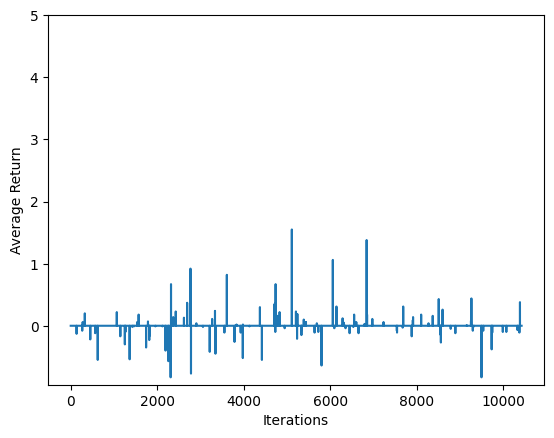

In [40]:
plt.plot(returns_test)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=5)

In [41]:
reward_money = returns_test.copy()

array_neg = []
array_pos = []
positive = 0
negative = 0
zero = 0
for reward in reward_money:
    if reward < 0:
        negative += 1
        array_neg.append(reward)
    elif reward > 0:
        positive += 1
        array_pos.append(reward)
    else:
        zero += 1
        
percent_neg = round((negative*100)/len(reward_money),2)
percent_pos = round((positive*100)/len(reward_money),2)
percent_zero = round((zero*100)/len(reward_money),2)

print("\rpositive: {}/{numero}\nnegative: {}/{numero}\nzero: {}/{numero}\n".format(positive, negative,zero
                                                                    ,numero=len(reward_money))
                                                                      , end="") # Not shown
print("Pos_percent {}%".format(percent_pos))
print("Neg_percent {}%".format(percent_neg))
print("zero_percent {}%".format(percent_zero))
print('max:'+str(max(reward_money)))
print('min:'+str(min(reward_money)))
print('total_money_win:' + str(sum(array_pos)))
print('total_money_loss:' + str(sum(array_neg)))
print('median_win:'+str(np.median(np.array(array_pos))))
print('median_neg:'+str(np.median(np.array(array_neg))))

positive: 57/10429
negative: 61/10429
zero: 10311/10429
Pos_percent 0.55%
Neg_percent 0.58%
zero_percent 98.87%
max:1.55
min:-0.83
total_money_win:14.92999996803701
total_money_loss:-12.71999991685152
median_win:0.16
median_neg:-0.11


In [ ]:
#import os
#from tf_agents.policies import policy_saver

#policy_dir = os.path.join('/home/jorge/Documentos/TFG/politicas', 'policy_funciona')
#tf_policy_saver = policy_saver.PolicySaver(agent.policy)

#tf_policy_saver.save(policy_dir)